In [2]:
import os
import sys

try:
    from google.colab import drive
    IN_COLAB = True
except ModuleNotFoundError as e:
    IN_COLAB = False

if IN_COLAB:
    drive.mount('/content/drive', force_remount=True)
    MY_DRIVE_PATH ='/content/drive/MyDrive/Technion/NLP/NLP-Sequence-Labeling/'
    sys.path.append(MY_DRIVE_PATH)
    os.chdir(MY_DRIVE_PATH)
    print(f"Current working directory at {os.getcwd()}")


Mounted at /content/drive
Current working directory at /content/drive/MyDrive/Technion/NLP/NLP-Sequence-Labeling


In [3]:
# Please do not change this cell because some hidden tests might depend on it.
import os

# Otter grader does not handle ! commands well, so we define and use our
# own function to execute shell commands.
def shell(commands, warn=True):
    """Executes the string `commands` as a sequence of shell commands.
     
       Prints the result to stdout and returns the exit status. 
       Provides a printed warning on non-zero exit status unless `warn` 
       flag is unset.
    """
    file = os.popen(commands)
    print (file.read().rstrip('\n'))
    exit_status = file.close()
    if warn and exit_status != None:
        print(f"Completed with errors. Exit status: {exit_status}\n")
    return exit_status

shell("""
ls requirements.txt >/dev/null 2>&1
if [ ! $? = 0 ]; then
 rm -rf .tmp
 git clone https://github.com/cs236299-2023-spring/project2.git .tmp
 mv .tmp/requirements.txt ./
 rm -rf .tmp
fi
pip install -q -r requirements.txt
""")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.0/164.0 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 91.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 119.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 kB 51.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 72.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
# Initialize Otter
import otter
grader = otter.Notebook()

$$
\renewcommand{\vect}[1]{\mathbf{#1}}
\renewcommand{\cnt}[1]{\sharp(#1)}
\renewcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\renewcommand{\softmax}{\operatorname{softmax}}
\renewcommand{\Prob}{\Pr}
\renewcommand{\given}{\,|\,}
$$

# 236299 - Introduction to Natural Language Processing
## Project 2: Sequence labeling – The slot filling task

# Introduction

The second segment of the project involves a sequence labeling task, in which the goal is to label the tokens in a text. Many NLP tasks have this general form. Most famously is the task of _part-of-speech labeling_ as you explored in lab 2-4, where the tokens in a text are to be labeled with their part of speech (noun, verb, preposition, etc.). In this project segment, however, you'll use sequence labeling to implement a system for filling the slots in a template that is intended to describe the meaning of an ATIS query. For instance, the sentence 

    What's the earliest arriving flight between Boston and Washington DC?
    
might be associated with the following slot-filled template: 

    flight_id
        fromloc.cityname: boston
        toloc.cityname: washington
        toloc.state: dc
        flight_mod: earliest arriving
    
You may wonder how this task is a sequence labeling task. We label each word in the source sentence with a tag taken from a set of tags that correspond to the slot-labels. For each slot-label, say `flight_mod`, there are two tags: `B-flight_mod` and `I-flight_mod`. These are used to mark the beginning (B) or interior (I) of a phrase that fills the given slot. In addition, there is a tag for other (O) words that are not used to fill any slot. (This technique is thus known as IOB encoding.) Thus the sample sentence would be labeled as follows:

| Token   | Label    |
| :------ | :----- | 
| `BOS` | `O` |
| `what's` | `O` |
| `the` | `O` |
| `earliest` | `B-flight_mod` |
| `arriving` | `I-flight_mod` |
| `flight` | `O` |
| `between` | `O` |
| `boston` | `B-fromloc.city_name` |
| `and` | `O` |
| `washington` | `B-toloc.city_name` |
| `dc` | `B-toloc.state_code` |
| `EOS` | `O` |

> See below for information about the `BOS` and `EOS` tokens. 

The template itself is associated with the question type for the sentence, perhaps as recovered from the sentence in the last project segment.

In this segment, you'll implement three methods for sequence labeling: a hidden Markov model (HMM) and two recurrent neural networks, a simple RNN and a long short-term memory network (LSTM). By the end of this homework, you should have grasped the pros and cons of the statistical and neural approaches.

## Goals

1. Implement an HMM-based approach to sequence labeling.
2. Implement an RNN-based approach to sequence labeling.
3. Implement an LSTM-based approach to sequence labeling.
4. Compare the performances of HMM and RNN/LSTM with different amounts of training data. Discuss the pros and cons of the HMM approach and the neural approach.

## Setup

In [5]:
import copy
import math
import matplotlib.pyplot as plt
import random
import csv

import wget
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import datasets

from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.pre_tokenizers import WhitespaceSplit
from tokenizers.processors import TemplateProcessing
from tokenizers import normalizers
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from transformers import PreTrainedTokenizerFast

from tqdm.auto import tqdm

In [6]:
# Set random seeds
seed = 1234
random.seed(seed)
torch.manual_seed(seed)

# GPU check, sets runtime type to "GPU" where available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Loading data

We download the ATIS dataset, already presplit into training, validation (dev), and test sets.

In [7]:
# Prepare to download needed data
def download_if_needed(filename, source='./', dest='./'):
    os.makedirs(data_path, exist_ok=True) # ensure destination
    os.path.exists(f"./{dest}{filename}") or wget.download(source + filename, out=dest)

source_path = "https://raw.githubusercontent.com/nlp-course/data/master/ATIS/"
data_path = "data/"

# Download files
for filename in ["atis.train.txt",
                 "atis.dev.txt",
                 "atis.test.txt"
                ]:
    download_if_needed(filename, source_path, data_path)

## Data preprocessing

We again use `datasets` and `tokenizers` to load data and convert words to indices in the vocabulary.

We treat words occurring fewer than three times in the training data as _unknown words_. They'll be replaced by the unknown word type `[UNK]`.

In [8]:
for split in ['train', 'dev', 'test']:
    in_file = f'data/atis.{split}.txt'
    out_file = f'data/atis.{split}.csv'
    
    with open(in_file, 'r') as f_in:
        with open(out_file, 'w') as f_out:
            text, tag = [], []
            writer = csv.writer(f_out)
            writer.writerow(('text','tag'))
            for line in f_in:
                if line.strip() == '':
                    writer.writerow((' '.join(text), ' '.join(tag)))
                    text, tag = [], []
                else:
                    token, label = line.split('\t')
                    text.append(token)
                    tag.append(label.strip())

Let's take a look at what each data file looks like.

In [9]:
shell('head "data/atis.train.csv"')

text,tag
BOS what is the cost of a round trip flight from pittsburgh to atlanta beginning on april twenty fifth and returning on may sixth EOS,O O O O O O O B-round_trip I-round_trip O O B-fromloc.city_name O B-toloc.city_name O O B-depart_date.month_name B-depart_date.day_number I-depart_date.day_number O O O B-return_date.month_name B-return_date.day_number O
BOS now i need a flight leaving fort worth and arriving in denver no later than 2 pm next monday EOS,O O O O O O O B-fromloc.city_name I-fromloc.city_name O O O B-toloc.city_name B-arrive_time.time_relative I-arrive_time.time_relative I-arrive_time.time_relative B-arrive_time.time I-arrive_time.time B-arrive_date.date_relative B-arrive_date.day_name O
BOS i need to fly from kansas city to chicago leaving next wednesday and returning the following day EOS,O O O O O O B-fromloc.city_name I-fromloc.city_name O B-toloc.city_name O B-depart_date.date_relative B-depart_date.day_name O O B-return_date.date_relative I-return_date.date_r

We use `datasets` to prepare the data.

In [10]:
atis = load_dataset('csv', data_files={'train':'data/atis.train.csv', \
                                       'val': 'data/atis.dev.csv', \
                                       'test': 'data/atis.test.csv'})
atis

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/download/streaming_download_manager.py:776: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  return pd.read_csv(xopen(filepath_or_buffer, "rb", use_auth_token=use_auth_token), **kwargs)


Generating val split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/download/streaming_download_manager.py:776: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  return pd.read_csv(xopen(filepath_or_buffer, "rb", use_auth_token=use_auth_token), **kwargs)


Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-06fdb349dacdfa96/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


/usr/local/lib/python3.10/dist-packages/datasets/download/streaming_download_manager.py:776: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  return pd.read_csv(xopen(filepath_or_buffer, "rb", use_auth_token=use_auth_token), **kwargs)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'tag'],
        num_rows: 4274
    })
    val: Dataset({
        features: ['text', 'tag'],
        num_rows: 572
    })
    test: Dataset({
        features: ['text', 'tag'],
        num_rows: 586
    })
})

In [11]:
train_data = atis['train']
val_data = atis['val']
test_data = atis['test']

train_data.shuffle(seed=seed)

Dataset({
    features: ['text', 'tag'],
    num_rows: 4274
})

We build tokenizers from the training data to tokenize both text and tag and convert them into word ids.

In [12]:
MIN_FREQ = 3
unk_token = '[UNK]'
pad_token = '[PAD]'
bos_token = '<bos>'

def train_tokenizers(dataset, min_freq):
    # Text tokenizer:
    text_tokenizer = Tokenizer(WordLevel(unk_token=unk_token))
    text_tokenizer.pre_tokenizer = WhitespaceSplit()
    text_tokenizer.normalizer = normalizers.Lowercase()

    text_trainer = WordLevelTrainer(min_frequency=min_freq, special_tokens=[pad_token, unk_token,bos_token])
    text_tokenizer.train_from_iterator(dataset['text'], trainer=text_trainer)
    text_tokenizer.post_processor = TemplateProcessing(single=f"{bos_token} $A", special_tokens=[(bos_token, text_tokenizer.token_to_id(bos_token))])

    # Tag tokenizer:
    tag_tokenizer = Tokenizer(WordLevel(unk_token=unk_token))
    tag_tokenizer.pre_tokenizer = WhitespaceSplit()

    tag_trainer = WordLevelTrainer(special_tokens=[pad_token, unk_token, bos_token])
    tag_tokenizer.train_from_iterator(dataset['tag'], trainer=tag_trainer)
    tag_tokenizer.post_processor = TemplateProcessing(single=f"{bos_token} $A", special_tokens=[(bos_token, tag_tokenizer.token_to_id(bos_token))])

    return text_tokenizer, tag_tokenizer

text_tokenizer, tag_tokenizer = train_tokenizers(train_data, MIN_FREQ)


We use `datasets.Dataset.map` to convert text into word ids. As shown in lab 1-5, first we need to wrap `tokenizer` with the `transformers.PreTrainedTokenizerFast` class to be compatible with the `datasets` library.

In [13]:
hf_text_tokenizer = PreTrainedTokenizerFast(tokenizer_object=text_tokenizer, pad_token=pad_token, unk_token=unk_token, bos_token=bos_token)

hf_tag_tokenizer = PreTrainedTokenizerFast(tokenizer_object=tag_tokenizer, pad_token=pad_token, unk_token=unk_token, bos_token=bos_token)

In [14]:
def encode(example):
    example['input_ids'] = hf_text_tokenizer(example['text']).input_ids
    example['tag_ids'] = hf_tag_tokenizer(example['tag']).input_ids
    return example

train_data = train_data.map(encode)
val_data = val_data.map(encode)
test_data = test_data.map(encode)

  0%|          | 0/4274 [00:00<?, ?ex/s]

  0%|          | 0/572 [00:00<?, ?ex/s]

  0%|          | 0/586 [00:00<?, ?ex/s]

We can get some sense of the datasets by looking at the size of the text and tag vocabularies.

In [15]:
# Compute size of vocabulary
text_vocab = text_tokenizer.get_vocab()
tag_vocab = tag_tokenizer.get_vocab()
vocab_size = len(text_vocab)
num_tags = len(tag_vocab)

print(f"Size of English vocabulary: {vocab_size}")
print(f"Number of tags: {num_tags}")

Size of English vocabulary: 518
Number of tags: 104


## Special tokens and tags

You'll have already noticed the `BOS` and `EOS`, special tokens that the dataset developers used to indicate the beginning and end of the sentence; we'll leave them in the data.

We've also prepended `<bos>` for both text and tag. `Tokenizers` will prepend these to the sequence of words and tags. This relieves us from estimating the initial distribution of tags and tokens in HMMs, since we always start with a token `<bos>` whose tag is also `<bos>`. We'll be able to refer to these tags as exemplified here:

In [16]:
print(f"""
Initial tag string: {bos_token}
Initial tag id:     {tag_vocab[bos_token]}
""")


Initial tag string: <bos>
Initial tag id:     2



Finally, since we will be providing the sentences in the training corpus in "batches", we willl force the sentences within a batch to be the same length by padding them with a special `[PAD]` token. Again, we can access that token as shown here:

In [17]:
print(f"""
Pad tag string: {pad_token}
Pad tag id:     {tag_vocab[pad_token]}
""")


Pad tag string: [PAD]
Pad tag id:     0



To load data in batched tensors, we use `torch.utils.data.DataLoader` for data splits, which enables us to iterate over the dataset under a given `BATCH_SIZE`. For the test set, we use a batch size of B, to make the decoding implementation easier.

In [18]:
BATCH_SIZE = 32     # batch size for training and validation

# Defines how to batch a list of examples together
def collate_fn(examples):
    batch = {}
    bsz = len(examples)
    input_ids, tag_ids = [], []
    for example in examples:
        input_ids.append(example['input_ids'])
        tag_ids.append(example['tag_ids'])
        
    max_length = max([len(word_ids) for word_ids in input_ids])

    tag_batch = torch.zeros(bsz, max_length).long().fill_(tag_vocab[pad_token]).to(device)
    text_batch = torch.zeros(bsz, max_length).long().fill_(text_vocab[pad_token]).to(device)
    for b in range(bsz):
        text_batch[b][:len(input_ids[b])] = torch.LongTensor(input_ids[b]).to(device)
        tag_batch[b][:len(tag_ids[b])] = torch.LongTensor(tag_ids[b]).to(device)
    
    batch['tag_ids'] = tag_batch
    batch['input_ids'] = text_batch
    return batch

def get_iterators(train_data, val_data, test_data):
    train_iter = torch.utils.data.DataLoader(train_data, 
                                            batch_size=BATCH_SIZE, 
                                            shuffle=True, 
                                            collate_fn=collate_fn)
    val_iter = torch.utils.data.DataLoader(val_data, 
                                        batch_size=BATCH_SIZE, 
                                        shuffle=False, 
                                        collate_fn=collate_fn)
    test_iter = torch.utils.data.DataLoader(test_data, 
                                            batch_size=BATCH_SIZE, 
                                            shuffle=False, 
                                            collate_fn=collate_fn)
    return train_iter, val_iter, test_iter

train_iter, val_iter, test_iter = get_iterators(train_data, val_data, test_data)

Now, we can iterate over the dataset. We used a non-trivial batch size to gain the benefit of training on multiple sentences at a shot. You'll need to be careful about the shapes of the various tensors that are being manipulated.

Each batch will be a tensor of size `batch_size x max_length`. Let's examine a batch.

In [19]:
# Get the first batch
batch = next(iter(train_iter))

# What's its shape? Should be batch_size x max_length.
print(f'Shape of batch text tensor: {batch["input_ids"].shape}\n')

# Extract the first sentence in the batch, both text and tags
first_sentence = batch['input_ids'][0]
first_tags = batch['tag_ids'][0]

# Print out the first sentence, as token ids and as text
print("First sentence in batch")
print(f"{first_sentence}")
print(f"{hf_text_tokenizer.decode(first_sentence)}\n")

print("First tags in batch")
print(f"{first_tags}")
print(f"{hf_tag_tokenizer.decode(first_tags)}")

Shape of batch text tensor: torch.Size([32, 21])

First sentence in batch
tensor([  2,   3,  82, 154,   7,  31,  50,  36,  14,  19,  20,  29,   9, 121,
        431,   4,   0,   0,   0,   0,   0], device='cuda:0')
<bos> bos how many flights are there between san francisco and philadelphia on august eighteenth eos [PAD] [PAD] [PAD] [PAD] [PAD]

First tags in batch
tensor([ 2,  3,  3,  3,  3,  3,  3,  3,  5,  8,  3,  4,  3, 13, 12,  3,  0,  0,
         0,  0,  0], device='cuda:0')
<bos> O O O O O O O B-fromloc.city_name I-fromloc.city_name O B-toloc.city_name O B-depart_date.month_name B-depart_date.day_number O [PAD] [PAD] [PAD] [PAD] [PAD]


The goal of this project is to predict the sequence of tags `batch['tag_ids']` given a sequence of words `batch['input_ids']`.

# Majority class labeling

As usual, we can get a sense of the difficulty of the task by looking at a simple baseline, tagging every token with the majority tag. Here's a table of tag frequencies for the most frequent tags:

In [20]:
def count_tags(iterator):
  tag_counts = torch.zeros(len(tag_vocab), device=device)

  for batch in iterator:
    tags = batch['tag_ids'].view(-1)
    tag_counts.scatter_add_(0, tags, torch.ones(tags.shape).to(device))
    # for i in range(tag_counts.shape[0]): tag_counts[tags[i]] += torch.ones(tags.shape)[i]

  ## Alternative untensorized implementation for reference
  # for batch in iterator:                # for each batch
  #   for sent_id in range(len(batch)):   # ... each sentence in the batch
  #     for tag in batch.tag[:, sent_id]: # ... each tag in the sentence
  #       tag_counts[tag] += 1            # bump the tag count

  # Ignore paddings
  tag_counts[tag_vocab[pad_token]] = 0
  return tag_counts

tag_counts = count_tags(train_iter)

for tag_id in range(len(tag_vocab)):
  print(f'{tag_id:3}  {hf_tag_tokenizer.decode(tag_id):30}{tag_counts[tag_id].item():3.0f}')

  0  [PAD]                           0
  1  [UNK]                           0
  2  <bos>                         4274
  3  O                             38967
  4  B-toloc.city_name             3751
  5  B-fromloc.city_name           3726
  6  I-toloc.city_name             1039
  7  B-depart_date.day_name        835
  8  I-fromloc.city_name           636
  9  B-airline_name                610
 10  B-depart_time.period_of_day   555
 11  I-airline_name                374
 12  B-depart_date.day_number      351
 13  B-depart_date.month_name      340
 14  B-depart_time.time            321
 15  B-round_trip                  311
 16  I-round_trip                  303
 17  B-depart_time.time_relative   290
 18  B-cost_relative               281
 19  B-flight_mod                  264
 20  I-depart_time.time            258
 21  B-stoploc.city_name           202
 22  B-city_name                   191
 23  B-arrive_time.time            182
 24  B-class_type                  181
 25  B-arrive_time.

It looks like the `'O'` (other) tag is, unsurprisingly, the most frequent tag (except for the padding tag). The proportion of tokens labeled with that tag (ignoring the padding tag) gives us a good baseline accuracy for this sequence labeling task. To verify that intuition, we can calculate the accuracy of the majority tag on the test set:

In [21]:
tag_counts_test = count_tags(test_iter)
majority_baseline_accuracy = (
  tag_counts_test[tag_vocab['O']] 
  / tag_counts_test.sum()
)
print(f'Baseline accuracy: {majority_baseline_accuracy:.3f}')

Baseline accuracy: 0.634


# HMM for sequence labeling

Having established the baseline to beat, we turn to implementing an HMM model.

## Notation

First, let's start with some notation. We use $\mathcal{V} = \langle \mathcal{V}_1, \mathcal{V}_2, \ldots \mathcal{V}_V \rangle$ to denote the vocabulary of word types and $Q = \langle{Q_1, Q_2, \ldots, Q_N} \rangle$ to denote the possible tags, which is the state space of the HMM. Thus $V$ is the number of word types in the vocabulary and $N$ is the number of states (tags).

We use $\vect{w} = w_1 \cdots w_T \in \mathcal{V}^T$ to denote the string of words at "time steps" $t$ (where $t$ varies from $1$ to $T$). Similarly, $\vect{q} = q_1 \cdots q_T \in Q^T$ denotes the corresponding sequence of states (tags).

## Training an HMM by counting

Recall that an HMM is defined via a transition matrix $A$, which stores the probability of moving from one state $Q_i$ to another $Q_j$, that is, 

$$A_{ij}=\Prob(q_{t+1}=Q_j  \given  q_t=Q_i)$$

and an emission matrix $B$, which stores the probability of generating word $\mathcal{V}_j$ given state $Q_i$, that is, 

$$B_{ij}= \Prob(w_t=\mathcal{V}_j  \given q_t= Q_i)$$

> As is typical in notating probabilities, we'll use abbreviations
>
\begin{align}
\Prob(q_{t+1} \given  q_t) &\equiv \Prob(q_{t+1}=Q_j  \given  q_t=Q_i) \\
\Prob(w_t  \given q_t) &\equiv \Prob(w_t=\mathcal{V}_j  \given q_t= Q_i)
\end{align}
>
> where the $i$ and $j$ are clear from context.

In our case, since the labels are observed in the training data, we can directly use counting to determine (maximum likelihood) estimates of $A$ and $B$.

### Goal 1(a): Find the transition matrix

The matrix $A$ contains the transition probabilities: $A_{ij}$ is the probability of moving from state $Q_i$ to state $Q_j$ in the training data, so that $\sum^{N}_{j = 1 } A_{ij} = 1$ for all $i$. 

We find these probabilities by counting the number of times state $Q_j$ appears right after state $Q_i$, as a proportion of all of the transitions from $Q_i$.

$$
A_{ij} = \frac{\cnt{Q_i, Q_j} + \delta}{\sum_k \left (\cnt{Q_i, Q_k}+\delta \right)}
$$

(In the above formula, we also used add-$\delta$ smoothing.)

Using the above definition, implement the method `train_A` in the `HMM` class below, which calculates and returns the $A$ matrix as a tensor of size $N \times N$.

> You'll want to go ahead and implement this part now, and test it below, before moving on to the next goal.

> Remember that the training data is being delivered to you batched.

### Goal 1(b): Find the emission matrix $B$

Similar to the transition matrix, the emission matrix contains the emission probabilities such that $B_{ij}$ is probability of word $w_t=\mathcal{V}_j$ conditioned on state $q_t=Q_i$.

We can find this by counting as well.
$$
B_{ij} = \frac{\cnt{Q_i, \mathcal{V}_j} + \delta}{\sum_k \left (\cnt{Q_i, \mathcal{V}_k} + \delta \right)}
       = \frac{\cnt{Q_i, \mathcal{V}_j} + \delta}{\cnt{Q_i} + \delta V}
$$

Using the above definitions, implement the `train_B` method in the `HMM` class below, which calculates and returns the $B$ matrix as a tensor of size $N \times V$.

> You'll want to go ahead and implement this part now, and test it below, before moving on to the next goal.

## Sequence labeling with a trained HMM

Now that you're able to train an HMM by estimating the transition matrix $A$ and the emission matrix $B$, you can apply it to the task of labeling a sequence of words $\vect{w} = w_1 \cdots w_T$. Our goal is to find the most probable sequence of tags $\vect{\hat q} \in Q^T$ given a sequence of words $\vect{w} \in \mathcal{V}^T$.

\begin{align*}
\vect{\hat q} &= \operatorname*{argmax}\limits_{\vect{q} \in Q^T}(\Prob(\vect{q} \given \vect{w})) \\
& = \operatorname*{argmax}_{\vect{q} \in Q^T}(\Prob(\vect{q},\vect{w})) \\
& = \operatorname*{argmax}_{\vect{q} \in Q^T}\left(\Pi^{T}_{t = 1} \Prob(w_{t} \given q_{t})\Prob(q_{t} \given q_{t-1})\right)
\end{align*}

where $\Prob(w_{t}=\mathcal{V}_j \given q_{t}=Q_i) = B_{ij}$, $\Prob(q_{t}=Q_j \given q_{t-1}=Q_{i})=A_{ij}$, and $q_0$ is the predefined initial tag `TAG.vocab.stoi[TAG.init_token]`.

### Goal 1(c): Viterbi algorithm

Implement the `predict` method, which should use the Viterbi algorithm to find the most likely sequence of tags for a sequence of `words`.

> Warning: It may take up to 30 minutes to tag the entire test set depending on your implementation. (A fully tensorized implementation can be much faster though.) We highly recommend that you begin by experimenting with your code using a _very small subset_ of the dataset, say two or three sentences, ramping up from there.

> Hint: Consider how to use vectorized computations where possible for speed.

## Evaluation

We've provided you with the `evaluate` function, which takes a dataset iterator and uses `predict` on each sentence in each batch, comparing against the gold tags, to determine the accuracy of the model on the test set.

In [22]:
from collections import deque, Counter
from itertools import islice


class HMMTagger:
    def __init__(self, hf_text_tokenizer, hf_tag_tokenizer, verbose: bool=True):
        self.hf_text_tokenizer = hf_text_tokenizer
        self.hf_tag_tokenizer = hf_tag_tokenizer

        self.V = len(self.hf_text_tokenizer)  # vocabulary size
        self.N = len(self.hf_tag_tokenizer)  # state space size

        self.initial_state_id = self.hf_tag_tokenizer.bos_token_id
        self.pad_state_id = self.hf_tag_tokenizer.pad_token_id
        self.pad_word_id = self.hf_text_tokenizer.pad_token_id

        self.verbose = verbose

    def train_A(self, iterator, delta):
        """Returns A for training dataset `iterator` using add-`delta` smoothing."""
        def sliding_window(iterable, n):
            """
            recipe from: https://docs.python.org/3/library/itertools.html
            """
            # sliding_window('ABCDEFG', 4) --> ABCD BCDE CDEF DEFG
            it = iter(iterable)
            window = deque(islice(it, n), maxlen=n)
            if len(window) == n:
                yield tuple(window)
            for x in it:
                window.append(x)
                yield tuple(window)

        def count_sliding_window_elements(sample_t, n: int=2, counter=None):
            # Flatten the tensor and convert it to a 1-dimensional list,
            # generate the tuples from the sliding window size `n`
            tuples = sliding_window(sample_t.tolist(), n)
            # Initialize a new Counter if counter is None
            counts = Counter() if counter is None else counter
            # Update the counter with the counts from the new tensor
            counts.update(tuples)
            return counts

        # Create A table
    
        A = torch.zeros(self.N, self.N, device=device)
    
        # TODO: Add your solution from Goal 1(a) here.
        #      The returned value should be a tensor for the A matrix
        #      of size N x N.
        pad_index = self.pad_state_id

        tuple_counts = Counter()
        for batch in iterator:
            tag_ids_batch, _ = batch['tag_ids'], batch['input_ids']
            for tag_ids in tag_ids_batch:
                count_sliding_window_elements(tag_ids, counter=tuple_counts)

        for (i,j), value in tuple_counts.items():
            A[i,j] = value
        # This should make the resulting matrix have 0's in the transitions to padding
        # as well as not count the paddings in the calculations for the probabilities.
        A[:, pad_index] = A[pad_index, :] = -delta
        # Ignore the padding token in the calculation for the smoothing
        denominator_sum = A.sum(axis=-1).reshape(-1, 1)
        A = (A + delta) / (denominator_sum + self.N * delta)
        # Set the probability to transition into/from padding to 0:
        A[:, pad_index] = A[pad_index, :] = 0.
        return A

    def train_B(self, iterator, delta):
        """Returns B for training dataset `iterator` using add-`delta` smoothing."""
        def count_emissions(emission, counter=None):
            # Initialize a new Counter if counter is None
            counts = Counter() if counter is None else counter
            # Update the counter with the counts from the new tensor
            counts.update(emission)
            return counts

        # Create B
        B = torch.zeros(self.N, self.V, device=device)

        # TODO: Add your solution from Goal 1 (b) here.
        #      The returned value should be a tensor for the $B$ matrix
        #      of size N x V.

        tag_token_counts = Counter()
        for batch in iterator:
            tag_ids_batch, input_ids_batch = batch['tag_ids'].tolist(), batch['input_ids'].tolist()
            for sample_tag_ids, sample_input_ids in zip(tag_ids_batch, input_ids_batch):
                count_emissions(list(zip(sample_tag_ids, sample_input_ids)), counter=tag_token_counts)
    
        for (i,j), value in tag_token_counts.items():
            B[i,j] = value
        # This should make the resulting matrix have 0's in the transitions to padding
        # as well as not count the paddings in the calculations for the probabilities.
        B[self.pad_state_id, :] = B[:, self.pad_word_id] = -delta
        # Ignore the padding token in the calculation for the smoothing
        denominator_sum = B.sum(axis=-1).reshape(-1, 1)
        B = (B + delta) / (denominator_sum + self.V * delta)
        # Set the probability to transition into/from padding to 0:
        B[self.pad_state_id, :] = B[:, self.pad_word_id] = 0
        return B

    def train_all(self, iterator, delta=0.01):
        """Stores A and B (actually, their logs) for training dataset `iterator`."""

        self.log_A: torch.Tensor = self.train_A(iterator, delta).log()
        self.log_B: torch.Tensor = self.train_B(iterator, delta).log()

    def _viterbi_decode(self, word_ids):
        seq_len = len(word_ids)
        # Create tensors to store the backpointers and viterbi variables
        backpointers = torch.full(size=(self.N, seq_len), fill_value=-1, device=device).to(int)
        # Initialize the viterbi variables in log space
        V = torch.zeros(size=(self.N, seq_len), device=device)  # Viterbi tensor
        # First state is <bos>
        V[:, 0] = -torch.inf
        V[self.initial_state_id, 0] = 0
        backpointers[:, 0] = self.initial_state_id

        for t in range(1, seq_len):
            # Using the previous viterbi column, calculate the next column using all the possible 
            # transitions given the emission word_id.
            V[:, t], backpointers[:, t] = (V[:, t - 1].unsqueeze(dim=1) + self.log_A + self.log_B[:, word_ids[t]].unsqueeze(dim=0)).max(dim=0)

        path_score, best_tag_id = V[:, -1].max(dim=0)

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id.item()]
        for t in range(seq_len - 1, 0, -1):  # Iterate every column backwards
            best_tag_id = backpointers[best_tag_id, t]
            best_path.insert(0, best_tag_id.item())

        # Make sure that the final token is a <bos> tag
        assert best_path[0] == self.initial_state_id  # Sanity check
        return path_score.item(), best_path

    
    def predict(self, words):
        """Returns the most likely sequence of tags for a sequence of `words`.
        Arguments:
          words: a tensor of size (seq_len,)
        Returns:
          a list of tag ids
        """
    
        # TODO: Add your solution from Goal 1 (c) here.
        #      The returned value should be a list of tag ids.
        _, bestpath = self._viterbi_decode(words)

        return bestpath

    def evaluate(self, iterator,):
        """Returns the model's token accuracy on a given dataset `iterator`."""
        correct = 0
        total = 0
        iterator = tqdm(iterator, position=0, leave=True) if self.verbose else iterator
        for batch in iterator:
            for sent_id in range(len(batch['input_ids'])):
                words = batch['input_ids'][sent_id]
                words = words[words.ne(self.pad_word_id)]  # remove paddings
                tags_gold = batch['tag_ids'][sent_id]
                tags_pred = self.predict(words)
                for (tag_gold, tag_pred) in zip(tags_gold, tags_pred):
                    if tag_gold == self.pad_state_id:  # stop once we hit padding
                        break
                    else:
                        total += 1
                        if tag_pred == tag_gold:
                            correct += 1
        return correct / total

Putting everything together, you should now be able to train and evaluate the HMM. A correct implementation can be expected to reach above **90% test set accuracy** after running the following cell.

In [23]:
# Instantiate and train classifier
hmm_tagger = HMMTagger(hf_text_tokenizer, hf_tag_tokenizer)
hmm_tagger.train_all(train_iter)

# Evaluate model performance
print(f'Training accuracy: {hmm_tagger.evaluate(train_iter):.3f}\n'
      f'Test accuracy:     {hmm_tagger.evaluate(test_iter):.3f}')

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Training accuracy: 0.915
Test accuracy:     0.906


# RNN for Sequence Labeling

HMMs work quite well for this sequence labeling task. Now let's take an alternative (and more trendy) approach: RNN/LSTM-based sequence labeling. Similar to the HMM part of this project, you will also need to train a model on the training data, and then use the trained model to decode and evaluate some testing data.

<img src="https://github.com/nlp-course/data/raw/master/Resources/rnn-unfolded-figure.png" width=600 align=right />

After unfolding an RNN, the cell at time $t$ generates the observed output $\vect{y}_t$ based on the input $\vect{x}_t$ and the hidden state of the previous cell $\vect{h}_{t-1}$, according to the following equations.

\begin{align*}
\vect{h}_t &=  \sigma(\vect{U} \vect{x}_t + \vect{V} \vect{h}_{t-1}) \\
\vect{\hat y}_t &= \softmax(\vect{W} \vect{h}_t)
\end{align*}

The parameters here are the elements of the matrices $\vect{U}$, $\vect{V}$, and $\vect{W}$. Similar to the last project segment, we will perform the forward computation, calculate the loss, and then perform the backward computation to compute the gradients with respect to these model parameters. Finally, we will adjust the parameters opposite the direction of the gradients to minimize the loss, repeating until convergence.

You've seen these kinds of neural network models before, for language modeling in lab 2-3 and sequence labeling in lab 2-5. The code there should be very helpful in implementing an `RNNTagger` class below. Consequently, we've provided very little guidance on the implementation. We do recommend you follow the steps below however.

## Goal 2(a): RNN training

Implement the forward pass of the RNN tagger and the loss function. A reasonable way to proceed is to implement the following methods:

1. `forward(self, text_batch)`: Performs the RNN forward computation over a whole `text_batch` (`batch.text` in the above data loading example). The `text_batch` will be of shape `max_length x batch_size`. You might run it through the following layers: an embedding layer, which maps each token index to an embedding of size `embedding_size` (so that the size of the mapped batch becomes `max_length x batch_size x embedding_size`); then an RNN, which maps each token embedding to a vector of `hidden_size` (the size of all outputs is `max_length x batch_size x hidden_size`); then a linear layer, which maps each RNN output element to a vector of size $N$ (which is commonly referred to as "logits", recall that $N=|Q|$, the size of the tag set).

This function is expected to return `logits`, which provides a logit for each tag of each word of each sentence in the batch (structured as a tensor of size `max_length x batch_size x N`). 

> You might find the following functions useful: 
>
> * [`nn.Embedding`](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html)
> * [`nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)
> * [`nn.RNN`](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html)

2. `compute_loss(self, logits, tags)`: Computes the loss for a batch by comparing `logits` of a batch returned by `forward` to `tags`, which stores the true tag ids for the batch. Thus `logits` is a tensor of size `max_length x batch_size x N`, and `tags` is a tensor of size `max_length x batch_size`. Note that the criterion functions in `torch` expect outputs of a certain shape, so you might need to perform some shape conversions.

> You might find [`nn.CrossEntropyLoss`](https://pytorch.org/docs/master/generated/torch.nn.CrossEntropyLoss.html) from the last project segment useful. Note that if you use `nn.CrossEntropyLoss` then you should not use a softmax layer at the end since that's already absorbed into the loss function. Alternatively, you can use [`nn.LogSoftmax`](https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html) as the final sublayer in the forward pass, but then you need to use [`nn.NLLLoss`](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html), which does not contain its own softmax. We recommend the former, since working in log space is usually more numerically stable.

> Be careful about the shapes/dimensions of tensors. You might find [`torch.Tensor.view`](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.view) useful for reshaping tensors.

3. `train_all(self, train_iter, val_iter, epochs=10, learning_rate=0.001)`: Trains the model on training data generated by the iterator `train_iter` and validation data `val_iter`.The `epochs` and `learning_rate` variables are the number of epochs (number of times to run through the training data) to run for and the learning rate for the optimizer, respectively. You can use the validation data to determine which model was the best one as the epocks go by. Notice that our code below assumes that during training the best model is stored so that `rnn_tagger.load_state_dict(rnn_tagger.best_model)` restores the parameters of the best model.

## Goal 2(b) RNN decoding

Implement a method to predict the tag sequence associated with a sequence of words:

1. `predict(self, text_batch)`: Returns the batched predicted tag sequences associated with a batch of sentences.
2. `def evaluate(self, iterator)`: Returns the accuracy of the trained tagger on a dataset provided by `iterator`.

In [24]:
class RNNBaseTagger(nn.Module):
    def __init__(self, verbose: bool=True, **kwargs):
        super().__init__()
        self.verbose = verbose

    def init_parameters(self, init_low=-0.2, init_high=0.2):
        """Initialize parameters. We usually use larger initial values for smaller models.
        See http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf for a more
        in-depth discussion.
        """
        for p in self.parameters():
            p.data.uniform_(init_low, init_high)

    def forward(self, text_batch):
        """Performs forward, returns logits.

        Arguments:
          text_batch: a tensor containing word ids of size (1 ,seq_len)
        Returns:
          logits: a tensor of size (B, seq_len, self.N)
        """
        raise NotImplementedError

    def compute_loss(self, logits, tags):
        return self.loss_function(logits.view(-1, self.N), tags.view(-1))

    def train_all(self, train_iter, val_iter, epochs=5, learning_rate=1e-3):
        # Switch the module to training mode
        self.train()
        # Use Adam to optimize the parameters
        optim = torch.optim.Adam(self.parameters(), lr=learning_rate)
        best_validation_accuracy = -float("inf")
        self.best_model = None
        # Run the optimization for multiple epochs
        for epoch in range(epochs):
            total = 0
            running_loss = 0.0
            iterator = tqdm(train_iter, position=0, leave=True) if self.verbose else train_iter
            for batch in iterator:
                # Zero the parameter gradients
                self.zero_grad()

                # Input and target
                words = batch["input_ids"]  # B, seq_len
                tags = batch["tag_ids"]  # B, seq_len

                # Run forward pass and compute loss along the way.
                logits = self.forward(words)
                loss = self.compute_loss(logits, tags)

                # Perform backpropagation
                (loss / words.size(1)).backward()

                # Update parameters
                optim.step()

                # Training stats
                total += 1
                running_loss += loss.item()

            # Evaluate and track improvements on the validation dataset
            validation_accuracy = self.evaluate(val_iter)
            if validation_accuracy > best_validation_accuracy:
                best_validation_accuracy = validation_accuracy
                self.best_model = copy.deepcopy(self.state_dict())
            epoch_loss = running_loss / total
            if self.verbose:
                print(
                    f"Epoch: {epoch} Loss: {epoch_loss:.4f} "
                    f"Validation accuracy: {validation_accuracy:.4f}"
                )

    def predict(self, text_batch):
        """Returns the most likely sequence of tags for a sequence of words in `text_batch`.

        Arguments:
          text_batch: a tensor containing word ids of size (B, seq_len)
        Returns:
          tag_batch: a tensor containing tag ids of size (B, seq_len)
        """
        raise NotImplementedError

    def evaluate(self, iterator):
        """Returns the model's performance on a given dataset `iterator`.

        Arguments:
          iterator
        Returns:
          overall accuracy
        """
        correct = 0
        total = 0
        pad_id = tag_vocab[pad_token]

        iterator = tqdm(iterator, position=0, leave=True) if self.verbose else iterator
        for batch in iterator:
            words = batch["input_ids"]  # B, seq_len
            tags = batch["tag_ids"]  # B, seq_len
            tags_pred = self.predict(words)  # B, seq_len
            mask = tags.ne(pad_id)
            cor = (tags == tags_pred)[mask]
            correct += cor.float().sum().item()
            total += mask.float().sum().item()

        return correct / total


class RNNTagger(RNNBaseTagger):
    def __init__(self, hf_text_tokenizer, hf_tag_tokenizer, embedding_size, hidden_size, **kwargs):
        super().__init__(**kwargs)
        self.hf_text_tokenizer = hf_text_tokenizer
        self.hf_tag_tokenizer = hf_tag_tokenizer

        self.N = len(self.hf_tag_tokenizer)   # tag vocab size
        self.V = len(self.hf_text_tokenizer)  # text vocab size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size

        # Create essential modules
        self.word_embeddings = nn.Embedding(self.V, embedding_size) # Lookup layer
        self.rnn = nn.RNN(input_size=embedding_size, 
                          hidden_size=hidden_size,
                          batch_first=True)
        self.hidden2output = nn.Linear(hidden_size, self.N)

        # Create loss function
        pad_id = self.hf_tag_tokenizer.pad_token_id
        self.loss_function = nn.CrossEntropyLoss(reduction='sum', ignore_index=pad_id)

        # Initialize parameters
        self.init_parameters()
    
    def forward(self, text_batch):
        """Performs forward, returns logits.
        
        Arguments: 
        text_batch: a tensor containing word ids of size (B, seq_len) 
        Returns:
        logits: a tensor of size (B, seq_len, self.N)
        """
        hidden = None # equivalent to setting hidden to a zero vector
        word_embeddings = self.word_embeddings(text_batch) # B, seq_len, embedding_size
        hidden_outputs, _ = self.rnn(word_embeddings, hidden)
        logits = self.hidden2output(hidden_outputs)
        return logits

    def predict(self, text_batch):
        """Returns the most likely sequence of tags for a sequence of words in `text_batch`.

        Arguments: 
        text_batch: a tensor containing word ids of size (B, seq_len) 
        Returns:
        tag_batch: a tensor containing tag ids of size (B, seq_len)
        """
        logits = self.forward(text_batch)  # B, seq_len, tag_len
        tag_batch = logits.argmax(dim=-1)  # B, seq_len
        return tag_batch


Now train your tagger on the training and validation set.
Run the cell below to train an RNN, and evaluate it. A proper implementation should reach about **95%+ accuracy**.

In [25]:
# Instantiate and train classifier
rnn_tagger = RNNTagger(hf_text_tokenizer, hf_tag_tokenizer, embedding_size=36, hidden_size=36).to(device)
rnn_tagger.train_all(train_iter, val_iter, epochs=10, learning_rate=0.001)
rnn_tagger.load_state_dict(rnn_tagger.best_model)

# Evaluate model performance
print(f'Training accuracy: {rnn_tagger.evaluate(train_iter):.3f}\n'
      f'Test accuracy:     {rnn_tagger.evaluate(test_iter):.3f}')

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 0 Loss: 1073.6640 Validation accuracy: 0.7252


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 1 Loss: 436.6478 Validation accuracy: 0.8429


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 2 Loss: 276.5553 Validation accuracy: 0.8984


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 3 Loss: 191.9602 Validation accuracy: 0.9258


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 4 Loss: 144.6115 Validation accuracy: 0.9382


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 5 Loss: 117.0159 Validation accuracy: 0.9447


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 6 Loss: 99.4772 Validation accuracy: 0.9475


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 7 Loss: 86.7189 Validation accuracy: 0.9542


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 8 Loss: 76.3596 Validation accuracy: 0.9574


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 9 Loss: 67.9187 Validation accuracy: 0.9609


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Training accuracy: 0.969
Test accuracy:     0.962


# LSTM for slot filling

Did your RNN perform better than HMM? How much better was it? Was that expected? 

RNNs tend to exhibit the [vanishing gradient problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem). To remedy this, the Long-Short Term Memory (LSTM) model was introduced. In PyTorch, we can simply use [`nn.LSTM`](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html). 

In this section, you'll implement an LSTM model for slot filling. If you've got the RNN model well implemented, this should be extremely straightforward. Just copy and paste your solution, change the call to `nn.RNN` to a call to `nn.LSTM`, and make any other minor adjustments that are necessary. In particular, LSTMs have _two_ recurrent parts, `h` and `c`. You'll thus need to initialize both of these when performing forward computations.

In [26]:
class LSTMTagger(RNNTagger):
    def __init__(self, hf_text_tokenizer, hf_tag_tokenizer, embedding_size, hidden_size, **kwargs):
        super().__init__(hf_text_tokenizer, hf_tag_tokenizer, embedding_size, hidden_size, **kwargs)
        self.rnn = nn.LSTM(input_size=embedding_size,
                           hidden_size=hidden_size,
                           batch_first=True)

        self.init_parameters(init_low=-0.7, init_high=0.7)

Run the cell below to train an LSTM, and evaluate it. A proper implementation should reach about **94%+ accuracy**.

In [27]:
# Instantiate and train classifier
lstm_tagger = LSTMTagger(hf_text_tokenizer, hf_tag_tokenizer, embedding_size=36, hidden_size=36).to(device)
lstm_tagger.train_all(train_iter, val_iter, epochs=10, learning_rate=0.001)
lstm_tagger.load_state_dict(lstm_tagger.best_model)

# Evaluate model performance
print(f'Training accuracy: {lstm_tagger.evaluate(train_iter):.3f}\n'
      f'Test accuracy:     {lstm_tagger.evaluate(test_iter):.3f}')

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 0 Loss: 1149.0388 Validation accuracy: 0.7802


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 1 Loss: 414.4078 Validation accuracy: 0.8483


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 2 Loss: 270.9712 Validation accuracy: 0.8971


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 3 Loss: 197.6690 Validation accuracy: 0.9222


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 4 Loss: 154.4940 Validation accuracy: 0.9342


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 5 Loss: 126.6431 Validation accuracy: 0.9403


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 6 Loss: 106.8560 Validation accuracy: 0.9486


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 7 Loss: 91.6023 Validation accuracy: 0.9560


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 8 Loss: 79.5504 Validation accuracy: 0.9595


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 9 Loss: 69.8169 Validation accuracy: 0.9631


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Training accuracy: 0.970
Test accuracy:     0.959


# Goal 4: Compare HMM to RNN/LSTM with different amounts of training data

Vary the amount of training data and compare the performance of HMM to RNN or LSTM (Since RNN is similar to LSTM, picking one of them is enough.) Discuss the pros and cons of HMM and RNN/LSTM based on your experiments.

> This part is more open-ended. We're looking for thoughtful experiments and analysis of the results, not any particular result or conclusion.

The code below shows how to subsample the training set with downsample ratio `ratio`. To speedup evaluation we only use 50 test samples.

In [ ]:
from typing import Tuple
import pandas as pd


def get_subsampled_iterators_and_tokenizers(ratio: float, val_size: int=50, test_size: int=50) -> Tuple[PreTrainedTokenizerFast, 
                                                    PreTrainedTokenizerFast, 
                                                    DataLoader, 
                                                    DataLoader, 
                                                    DataLoader]:
    """
    Subsamples the training dataset by a factor of `ratio`, subsamples both test and validation sets
    into constant sizes (val_size and test_size correspondingly)

    Returns:
    --------
    hf_text_tokenizer : PreTrainedTokenizerFast
    hf_tag_tokenizer : PreTrainedTokenizerFast
    train_iter : DataLoader
    val_iter : DataLoader
    test_iter : DataLoader
    """

    # Set random seeds to make sure subsampling is the same for HMM and RNN
    random.seed(seed)
    torch.manual_seed(seed)

    atis = load_dataset('csv', data_files={'train':'data/atis.train.csv', \
                                        'val': 'data/atis.dev.csv', \
                                        'test': 'data/atis.test.csv'})
    train_data = atis['train']
    val_data = atis['val']
    test_data = atis['test']

    # Subsample
    train_data = train_data.shuffle(seed=seed)
    train_data = train_data.select(list(range(len(train_data)))[:int(math.floor(len(train_data)*ratio))])
    val_data = val_data.shuffle(seed=seed)
    val_data = val_data.select(list(range(len(val_data)))[:val_size])
    test_data = test_data.shuffle(seed=seed)
    test_data = test_data.select(list(range(len(test_data)))[:test_size])

    # Rebuild vocabulary
    text_tokenizer, tag_tokenizer = train_tokenizers(train_data, MIN_FREQ)

    # Encode data
    hf_text_tokenizer = PreTrainedTokenizerFast(tokenizer_object=text_tokenizer, pad_token=pad_token, unk_token=unk_token, bos_token=bos_token)

    hf_tag_tokenizer = PreTrainedTokenizerFast(tokenizer_object=tag_tokenizer, pad_token=pad_token, unk_token=unk_token, bos_token=bos_token)

    def encode(example):
        example['input_ids'] = hf_text_tokenizer(example['text']).input_ids
        example['tag_ids'] = hf_tag_tokenizer(example['tag']).input_ids
        return example

    train_data = train_data.map(encode)
    val_data = val_data.map(encode)
    test_data = test_data.map(encode)

    # Create iterators
    train_iter, val_iter, test_iter = get_iterators(train_data, val_data, test_data)

    return hf_text_tokenizer, hf_tag_tokenizer, train_iter, val_iter, test_iter

def benchmark_models(ratio: float, val_size: int=50, test_size: int=50) -> pd.DataFrame:
    global test_iter
    hf_text_tokenizer, hf_tag_tokenizer, local_train_iter, local_val_iter, local_test_iter = get_subsampled_iterators_and_tokenizers(ratio, val_size, test_size)
    
    # Instantiate and train classifier
    hmm_tagger = HMMTagger(hf_text_tokenizer, hf_tag_tokenizer, verbose=False)
    hmm_tagger.train_all(local_train_iter)

    # Evaluate model performance
    hmm_train = hmm_tagger.evaluate(local_train_iter)
    hmm_test = hmm_tagger.evaluate(local_test_iter)

    # Instantiate and train classifier
    rnn_tagger = RNNTagger(hf_text_tokenizer, hf_tag_tokenizer, embedding_size=36, hidden_size=36, verbose=False).to(device)
    rnn_tagger.train_all(local_train_iter, local_val_iter, epochs=10, learning_rate=0.001)

    # Evaluate model performance
    rnn_train = rnn_tagger.evaluate(local_train_iter)
    rnn_test = rnn_tagger.evaluate(local_test_iter)


    # Instantiate and train classifier
    lstm_tagger = LSTMTagger(hf_text_tokenizer, hf_tag_tokenizer, embedding_size=36, hidden_size=36, verbose=False).to(device)
    lstm_tagger.train_all(local_train_iter, local_val_iter, epochs=10, learning_rate=0.001)

    # Evaluate model performance
    lstm_train = lstm_tagger.evaluate(local_train_iter)
    lstm_test = lstm_tagger.evaluate(local_test_iter)

    df: pd.DataFrame = pd.DataFrame(
        data = [
            ['HMM Tagger', float(ratio),hmm_train, hmm_test],
            ['RNN Tagger', float(ratio), rnn_train, rnn_test],
            ['LSTM Tagger', float(ratio), lstm_train, lstm_test],
        ],
        columns=['model', 'ratio', 'train', 'test']
    )
    df.reset_index(inplace=True, drop=True)
    return df

ratios = torch.linspace(0.1, 1, 10)
df = pd.DataFrame()
ratios_pbar = tqdm(ratios, position=0, leave=True)
for ratio in ratios_pbar:
    ratios_pbar.set_description(f'Running ratio {ratio:.2f} benchmark')
    df = pd.concat([benchmark_models(ratio), df])

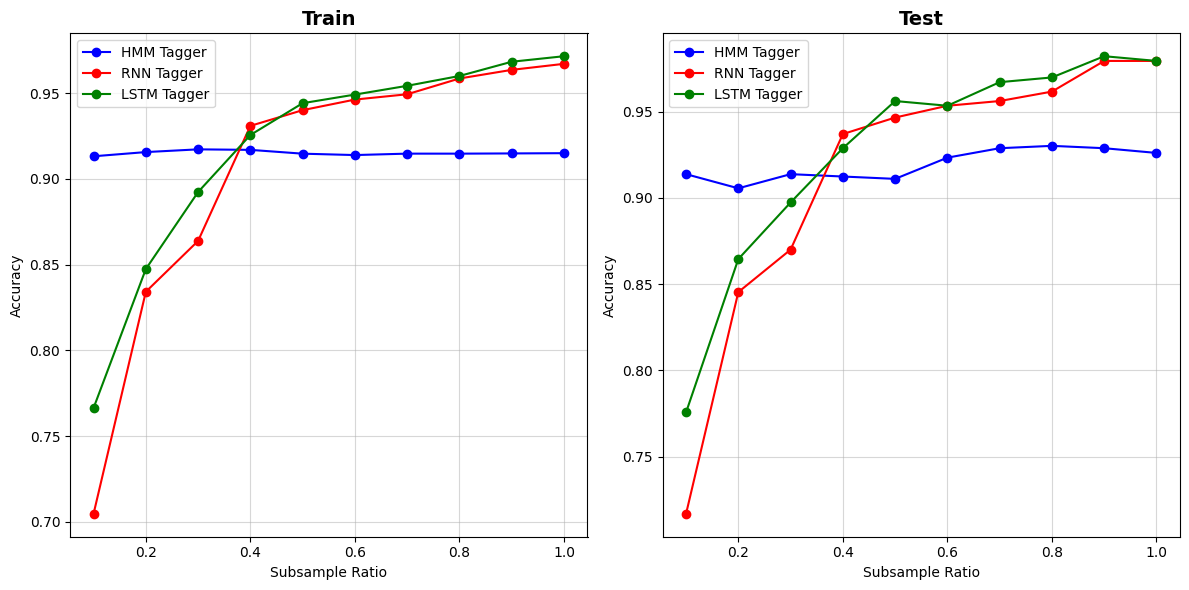

In [30]:
# Create a list of unique models in the DataFrame
models = df['model'].unique()

# Create a dictionary to map each model to a color
color_map = {models[0]: 'blue', models[1]: 'red', models[2]: 'green'}

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the training accuracy for each model
for model in models:
    model_data = df[df['model'] == model]
    ax1.plot(model_data['ratio'], model_data['train'], 'o-', label=model, color=color_map[model])

# Set the title, labels, and legend for the left subplot
ax1.set_title('Train', fontsize=14, fontweight='bold')
ax1.set_xlabel('Subsample Ratio')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Add gridlines to the left subplot
ax1.grid(alpha=0.5)

# Plot the test accuracy for each model
for model in models:
    model_data = df[df['model'] == model]
    ax2.plot(model_data['ratio'], model_data['test'], 'o-', label=model, color=color_map[model])

# Set the title, labels, and legend for the right subplot
ax2.set_title('Test', fontsize=14, fontweight='bold')
ax2.set_xlabel('Subsample Ratio')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Add gridlines to the right subplot
ax2.grid(alpha=0.5)

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

In the graphs we see the trendline correlating the ratio of the training data used to train the models and the resulting accuracy per each of the train and test corpos.
As expected we observe an increasing in accuracy with more data used for training in both RNN and LSTM models.
However for the HMM model we see a mostly flat line with a slight increase in accuracy of testing with more data used.

These result may indicate the following:
1) There is enough statistical information in the training data to achieve a high accuracy (HMM)
2) The dataset is "simple" in the sense that RNN and LSTM models achive similar accuracy growth despite LSTM being more complex of a model.
3) In very low data regimes (less than 30% of the data) the HMM model is more accurate than the RNN and LSTM models as it is less complex and thus less prone to overfitting.  
In general since HMM is statistical model and RNN and LSTM are not, we expect the HMM model to be more accurate in "low" data-statisically significant regimes.

<!-- BEGIN QUESTION -->

# Debrief

**Question:** We're interested in any thoughts you have about this project segment so that we can improve it for later years, and to inform later segments for this year. Please list any issues that arose or comments you have to improve the project segment. Useful things to comment on include the following: 

* Was the project segment clear or unclear? Which portions?
* Were the readings appropriate background for the project segment? 
* Are there additions or changes you think would make the project segment better?

<!--
BEGIN QUESTION
name: open_response_debrief
manual: true
-->

_Type your answer here, replacing this text._

<!-- END QUESTION -->



# Instructions for submission of the project segment

This project segment should be submitted to Gradescope at <https://rebrand.ly/project2-submit-code> and <https://rebrand.ly/project2-submit-pdf>, which will be made available some time before the due date.

Project segment notebooks are manually graded, not autograded using otter as labs are. (Otter is used within project segment notebooks to synchronize distribution and solution code however.) **We will not run your notebook before grading it.** Instead, we ask that you submit the already freshly run notebook. The best method is to "restart kernel and run all cells", allowing time for all cells to be run to completion. You should submit your code to Gradescope at the code submission assignment at <https://rebrand.ly/project2-submit-code>.

We also request that you **submit a PDF of the freshly run notebook**. The simplest method is to use "Export notebook to PDF", which will render the notebook to PDF via LaTeX. If that doesn't work, the method that seems to be most reliable is to export the notebook as HTML (if you are using Jupyter Notebook, you can do so using `File -> Print Preview`), open the HTML in a browser, and print it to a file. Then make sure to add the file to your git commit. Please name the file the same name as this notebook, but with a `.pdf` extension. (Conveniently, the methods just described will use that name by default.) You can then perform a git commit and push and submit the commit to Gradescope at <https://rebrand.ly/project2-submit-pdf>.